### DiffuseVAE Formulation 1 (128 x 128) CelebA

In [1]:
# prompt: mount to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import kagglehub
from torch.utils.data import DataLoader, Subset
from pathlib import Path
from PIL import Image
from torchvision.datasets import ImageFolder

import torchvision.utils as vutils
from diffusers import UNet2DModel, DDPMScheduler
import numpy as np

import torch.nn.functional as F


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters for VAE
IMG_SIZE = 128
LATENT_DIM = 128
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 50

In [ ]:
# # Preparing the dataset

# # Download dataset using kagglehub
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# data_dir = Path(path) / "img_align_celeba"

# # Dataset transformation
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize to 128x128
#     transforms.ToTensor(),
# ])

# # Load CelebA dataset from KaggleHub
# dataset = ImageFolder(root=str(data_dir.parent), transform=transform)

# # Select random 80k images from first 162770 images
# torch.manual_seed(42)
# indices = torch.randperm(162770)[:80000]
# train_dataset = Subset(dataset, indices.tolist())

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [4]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        x = self.fc_decode(z).view(z.size(0), 256, 8, 8)
        return self.decoder(x)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [5]:
TRAIN_VAE = False # set to true for new model

In [7]:
# Train the model
vae = VAE(LATENT_DIM).to(device)

if not TRAIN_VAE:
  # Load pretrained model
  PATH = "/content/vae_model_celeba_50_convention_gpt.pth"
  vae.load_state_dict(torch.load(PATH))
  print(f"VAE model at {PATH} loaded successfully!")
else:
  optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

  for epoch in range(EPOCHS):
      vae.train()
      train_loss = 0
      for imgs, _ in train_loader:
          imgs = imgs.to(device)
          optimizer.zero_grad()
          recon_imgs, mu, logvar = vae(imgs)
          loss = loss_function(recon_imgs, imgs, mu, logvar)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss/len(dataset):.4f}")

  # Save the trained model
  torch.save(vae.state_dict(), "/content/vae_model_celeba_50_2.pth")

  print("Training complete!")

VAE model at /content/vae_model_celeba_50_convention_gpt.pth loaded successfully!


In [8]:
# Display some reconstructions
def show_reconstructions(loader, title):
    vae.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs.to(device)
        recon_imgs, _, _ = vae(imgs)
        imgs, recon_imgs = imgs.cpu(), recon_imgs.cpu()
        fig, axes = plt.subplots(2, 8, figsize=(12, 4))
        for i in range(8):
            axes[0, i].imshow(imgs[i].permute(1, 2, 0))
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_imgs[i].permute(1, 2, 0))
            axes[1, i].axis('off')
        plt.suptitle(title)
        plt.show()
    return recon_imgs

In [ ]:
# recon_imgs = show_reconstructions(train_loader, "Train Data Reconstructions")

In [9]:
BATCH_SIZE = 16
EPOCHS = 50
LR = 2e-4
TOTAL_TIMESTEPS=1000

In [10]:
# Preparing the dataset

# Download dataset using kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
data_dir = Path(path) / "img_align_celeba"

# Dataset transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),
])

# Load CelebA dataset from KaggleHub
dataset = ImageFolder(root=str(data_dir.parent), transform=transform)

# Select random 80k images from first 162770 images
torch.manual_seed(42)
indices = torch.randperm(162770)[:10000]
train_dataset = Subset(dataset, indices.tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
# Data Loading and Preprocessing
# transform = transforms.Compose([
#     transforms.CenterCrop(178),  # Crop center to remove background
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
# ])
# import kagglehub
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# torch.manual_seed(42)
# indices = torch.randperm(162770)[:80000] # 80k subset of training image indices
# indices = torch.randperm(162770)[:10000] # 80k subset of training image indices

# dataset = datasets.ImageFolder(root=path, transform=transform)
# dataset = Subset(dataset, indices)  # Create subset of dataset

# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [11]:
# Define the UNet model

# Define your diffusion U-Net model (accepting 6-channel input: x_t + x̂₀)
diffusion_model = UNet2DModel(
    sample_size=64,         # <-- set to 64 for 64x64 images
    in_channels=6,          # x_t (3) + x̂₀ (3)
    out_channels=3,
    layers_per_block=2,
    block_out_channels=[64, 128, 256, 512],  # you can remove the last 512 if memory is an issue
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "AttnUpBlock2D")
).to(device)


# Diffusion scheduler (Using cosine beta schedule)
betas = np.linspace(1e-5, 1e-2, TOTAL_TIMESTEPS, dtype=np.float32)

scheduler = DDPMScheduler(
    num_train_timesteps=TOTAL_TIMESTEPS,
    trained_betas=torch.tensor(betas, dtype=torch.float32, device=device)
)

# Optimizer with Cosine Annealing LR Scheduler
optimizer = optim.AdamW(diffusion_model.parameters(), lr=LR, betas=(0.9, 0.999), weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

/usr/local/lib/python3.11/dist-packages/diffusers/schedulers/scheduling_ddpm.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.betas = torch.tensor(trained_betas, dtype=torch.float32)


In [12]:
def train_ddpm_step(vae, diffusion_model, scheduler, optimizer, real_images):
    diffusion_model.train()
    optimizer.zero_grad()

    # Get VAE reconstruction
    with torch.no_grad():
        z,mu,logvar = vae.encode(real_images)
        x_hat_0 = vae.decode(z)               # shape: (B, 3, 128, 128)

    # Sample random timestep t
    bsz = real_images.size(0)
    t = torch.randint(0, scheduler.num_train_timesteps, (bsz,), device=real_images.device).long()

    real_images = F.interpolate(real_images, size=(64, 64), mode='bilinear', align_corners=False)

    # Sample noise and create x_t
    noise = torch.randn_like(real_images)
    x_t = scheduler.add_noise(real_images, noise, t)

    x_hat_0 = F.interpolate(x_hat_0, size=(64, 64), mode='bilinear', align_corners=False)
    x_t = F.interpolate(x_t, size=(64, 64), mode='bilinear', align_corners=False)

    # Concatenate x_t and x̂₀
    model_input = torch.cat([x_t, x_hat_0], dim=1)  # shape: (B, 6, 64, 64)

    # Predict noise
    pred_noise = diffusion_model(model_input, timestep=t).sample


    # Loss (mean squared error between predicted noise and true noise)
    loss = nn.MSELoss()(pred_noise, noise)
    loss.backward()
    optimizer.step()

    return loss.item()

In [13]:
# === 6. Assume you have a pretrained VAE ===
# Must implement: encode(x) and decode(z)
vae = VAE(LATENT_DIM).to(device)

# Load pretrained model
vae.load_state_dict(torch.load("/content/vae_model_celeba_50_convention_gpt.pth"))
vae.eval()  # Freeze VAE
for p in vae.parameters():
    p.requires_grad = False


In [16]:
# prompt: load the diffusion model from Epoch 3

# Load the diffusion model from epoch 3
epoch_num = 2
diffusion_model.load_state_dict(torch.load(f"/content/drive/MyDrive/diffusion_celeba_epoch3.pth"))
print(f"Diffusion model loaded from epoch {epoch_num}")

# Now you can use the loaded diffusion_model for inference or further training

Diffusion model loaded from epoch 2


In [15]:
for epoch in range(EPOCHS):
    total_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        loss = train_ddpm_step(vae, diffusion_model, scheduler, optimizer, images)
        total_loss += loss

        if i % 100 == 0:
            print(f"Epoch {epoch+1} | Step {i} | Loss: {loss:.4f}")

            torch.save(diffusion_model.state_dict(), f"/content/drive/MyDrive/diffusion_celeba_epoch{epoch}_{i}.pth")


    # Every epoch save checkpoint
    torch.save(diffusion_model.state_dict(), f"/content/drive/MyDrive/diffusion_celeba_epoch{epoch}.pth")

    lr_scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1 | Step 0 | Loss: 0.0238
Epoch 1 | Step 100 | Loss: 0.0231
Epoch 1 | Step 200 | Loss: 0.0318
Epoch 1 | Step 300 | Loss: 0.0087
Epoch 1 | Step 400 | Loss: 0.0133
Epoch 1 | Step 500 | Loss: 0.0129
Epoch 1 | Step 600 | Loss: 0.0160
Epoch 1 completed. Avg Loss: 0.0220
Epoch 2 | Step 0 | Loss: 0.0095
Epoch 2 | Step 100 | Loss: 0.0414
Epoch 2 | Step 200 | Loss: 0.0052
Epoch 2 | Step 300 | Loss: 0.0159
Epoch 2 | Step 400 | Loss: 0.0636
Epoch 2 | Step 500 | Loss: 0.0582
Epoch 2 | Step 600 | Loss: 0.0165
Epoch 2 completed. Avg Loss: 0.0195
Epoch 3 | Step 0 | Loss: 0.0360
Epoch 3 | Step 100 | Loss: 0.0058
Epoch 3 | Step 200 | Loss: 0.0111
Epoch 3 | Step 300 | Loss: 0.0168
Epoch 3 | Step 400 | Loss: 0.0088
Epoch 3 | Step 500 | Loss: 0.0162
Epoch 3 | Step 600 | Loss: 0.0462
Epoch 3 completed. Avg Loss: 0.0190
Epoch 4 | Step 0 | Loss: 0.0201
Epoch 4 | Step 100 | Loss: 0.0161
Epoch 4 | Step 200 | Loss: 0.0246
Epoch 4 | Step 300 | Loss: 0.0068
Epoch 4 | Step 400 | Loss: 0.0079
Epoch 4 | Step 5

KeyboardInterrupt: 

In [17]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_images(images, title=""):
    # images = (images.clamp(-1, 1) + 1) / 2  # Normalize to [0, 1]
    grid = make_grid(images, nrow=5)
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(npimg)
    plt.axis("off")
    plt.show()


In [18]:
@torch.no_grad()
def sample_from_diffuse_vae(vae, diffusion_model, scheduler, num_samples):
    vae.eval()
    diffusion_model.eval()

    # Sample z ~ N(0, I)
    z = torch.randn((num_samples, LATENT_DIM)).to(device)

    # Get VAE reconstructions (x̂₀) from latent
    x_hat_0 = vae.decode(z)  # shape: (num_samples, 3, 64, 64)
    x_hat_0 = F.interpolate(x_hat_0, size=(64, 64), mode='bilinear', align_corners=False)
    show_images(x_hat_0, title="VAE reconstructions")

    # Start from pure Gaussian noise
    x_t = torch.randn_like(x_hat_0)

    for t in reversed(range(scheduler.config.num_train_timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Prepare model input
        model_input = torch.cat([x_t, x_hat_0], dim=1)  # (B, 6, 64, 64)

        # Predict noise
        noise_pred = diffusion_model(model_input, t_batch).sample

        # Loop over batch because DDPMScheduler.step doesn't support batched t
        x_t_next = []
        for i in range(num_samples):
            out = scheduler.step(
                model_output=noise_pred[i].unsqueeze(0),
                timestep=t_batch[i].item(),
                sample=x_t[i].unsqueeze(0)
            )
            x_t_next.append(out.prev_sample)

        # Stack outputs back to a batch
        x_t = torch.cat(x_t_next, dim=0)

    return x_t  # final denoised sample


def reconstruct_with_diffuse_vae(vae, diffusion_model, scheduler, real_images, num_samples=10):
    diffusion_model.eval()
    vae.eval()

    images = real_images[:num_samples].to(device)

    with torch.no_grad():
        z = vae.encode(images).sample()
        x_hat_0 = vae.decode(z)

        # Start from noise
        x_t = torch.randn_like(x_hat_0)

        for t in reversed(range(scheduler.num_train_timesteps)):
            t_batch = torch.tensor([t] * num_samples, device=device)
            model_input = torch.cat([x_t, x_hat_0], dim=1)
            noise_pred = diffusion_model(model_input, timestep=t_batch).sample
            x_t = scheduler.step(noise_pred, t_batch, x_t).prev_sample

        return x_t, images  # Return both reconstructed and original


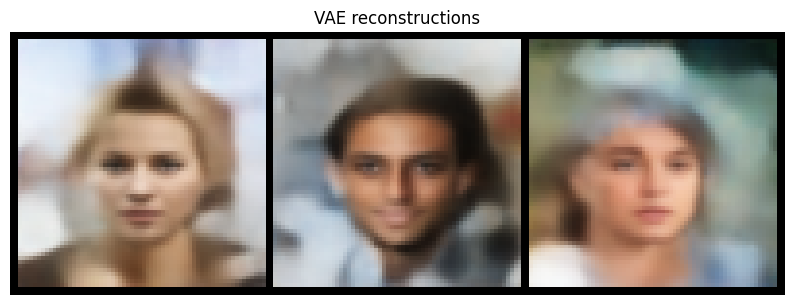

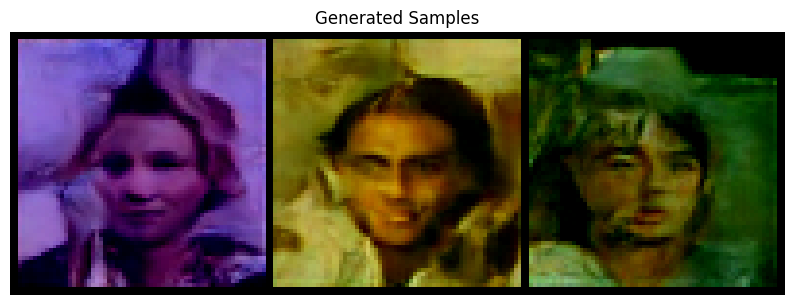

AttributeError: 'tuple' object has no attribute 'sample'

In [20]:
# 1. Generate 10 samples from scratch
samples = sample_from_diffuse_vae(vae, diffusion_model, scheduler, num_samples=3)
show_images(samples, title="Generated Samples")

# 2. Reconstruct 10 real images
real_batch = next(iter(train_loader))[0]
recon, originals = reconstruct_with_diffuse_vae(vae, diffusion_model, scheduler, real_batch, num_samples=3)

show_images(originals, title="Originals")
show_images(recon, title="Reconstructed via VAE + DDPM")
